In [1]:
# Importations de base
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Chargement des données MNIST

Charger le dataset MNIST, qui contient des images 28x28 de chiffres manuscrits (0 à 9).
Ensuite, tu divises les données en :

    Entraînement (Train) : 49 000 images

    Validation (Val) : 7 000 images

    Test : 14 000 images

In [2]:
# Chargement et split des données
def load_data():
    (train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

    # Combinaison pour nouveau split
    all_images = np.concatenate([train_val_images, test_images])
    all_labels = np.concatenate([train_val_labels, test_labels])

    # Split 80% train/val - 20% test
    train_val_images, test_images, train_val_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=0.2, random_state=42)

    # Split 70% train - 10% val
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_val_images, train_val_labels, test_size=0.125, random_state=42)

    print(f"\nRépartition des données:")
    print(f"Train: {len(train_images)} images")
    print(f"Validation: {len(val_images)} images")
    print(f"Test: {len(test_images)} images")

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# Chargement initial
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Répartition des données:
Train: 49000 images
Validation: 7000 images
Test: 14000 images


Partie 2: Préparation des Données

 Pour le modèle Dense :

    Les images sont aplaties (28x28 → 784) car un réseau dense ne peut pas traiter des images 2D directement.

    Normalisation des pixels (valeurs entre 0 et 1).

    One-hot encoding des labels pour la classification multiclasse (0 → [1,0,0,...], 1 → [0,1,0,...], etc.)

Pour le modèle Dense (Fully Connected)

In [3]:
# Pour modèle Dense
def prepare_dense_data(train_images, val_images, test_images):
    # Aplatissement
    train_flat = train_images.reshape(-1, 28*28)
    val_flat = val_images.reshape(-1, 28*28)
    test_flat = test_images.reshape(-1, 28*28)

    # Normalisation
    train_flat = train_flat.astype('float32') / 255
    val_flat = val_flat.astype('float32') / 255
    test_flat = test_flat.astype('float32') / 255

    # One-hot encoding
    train_labels_cat = to_categorical(train_labels)
    val_labels_cat = to_categorical(val_labels)
    test_labels_cat = to_categorical(test_labels)

    return (train_flat, train_labels_cat), (val_flat, val_labels_cat), (test_flat, test_labels_cat)

Pour le modèle CNN

Les images sont gardées en 2D avec 1 canal (grayscale), donc format (28, 28, 1).

Normalisation aussi ici.

In [4]:
def prepare_cnn_data(train_images, val_images, test_images):
    # Redimensionnement
    train_cnn = train_images.reshape(-1, 28, 28, 1)
    val_cnn = val_images.reshape(-1, 28, 28, 1)
    test_cnn = test_images.reshape(-1, 28, 28, 1)

    # Normalisation
    train_cnn = train_cnn.astype('float32') / 255
    val_cnn = val_cnn.astype('float32') / 255
    test_cnn = test_cnn.astype('float32') / 255

    return (train_cnn, train_labels_cat), (val_cnn, val_labels_cat), (test_cnn, test_labels_cat)

# Préparation
print("\nPréparation des données...")
(train_flat, train_labels_cat), (val_flat, val_labels_cat), (test_flat, test_labels_cat) = prepare_dense_data(train_images, val_images, test_images)
(train_cnn, _), (val_cnn, _), (test_cnn, _) = prepare_cnn_data(train_images, val_images, test_images)


Préparation des données...


Partie 3: Construction et Entraînement du Modèle Dense

Créer un modèle dense (fully connected) avec :

    2 couches cachées (Dense(512) puis Dense(256)) avec activation ReLU.

    1 couche de sortie (Dense(10)) avec softmax pour prédire les 10 chiffres.

In [5]:
def build_dense_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(28*28,)),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

print("\nConstruction du modèle Dense...")
dense_model = build_dense_model()

# Entraînement
print("Entraînement en cours...")
history_dense = dense_model.fit(
    train_flat, train_labels_cat,
    epochs=10,
    batch_size=128,
    validation_data=(val_flat, val_labels_cat))

# Evaluation
test_loss_dense, test_acc_dense = dense_model.evaluate(test_flat, test_labels_cat)
print(f"\nPerformance du modèle Dense - Précision: {test_acc_dense:.4f}")


Construction du modèle Dense...
Entraînement en cours...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8718 - loss: 0.4499 - val_accuracy: 0.9630 - val_loss: 0.1234
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9725 - loss: 0.0920 - val_accuracy: 0.9723 - val_loss: 0.0912
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9827 - loss: 0.0572 - val_accuracy: 0.9746 - val_loss: 0.0878
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9876 - loss: 0.0389 - val_accuracy: 0.9769 - val_loss: 0.0828
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9913 - loss: 0.0269 - val_accuracy: 0.9744 - val_loss: 0.0881
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9931 - loss: 0.0231 - val_accuracy: 0.9767 - val_loss: 0.0871
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9949 - loss: 0.0164 - val_accuracy: 0.9797 - val_loss: 0.0877
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9955 - loss: 0.0127 - val_a

Partie 4: Construction et Entraînement du Modèle CNN

Créer un modèle CNN avec :

    2 blocs convolution + pooling

    1 couche dense de 64 neurones

    1 couche softmax finale

In [6]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

print("\nConstruction du modèle CNN...")
cnn_model = build_cnn_model()

# Entraînement
print("Entraînement en cours...")
history_cnn = cnn_model.fit(
    train_cnn, train_labels_cat,
    epochs=10,
    batch_size=128,
    validation_data=(val_cnn, val_labels_cat))

# Evaluation
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_cnn, test_labels_cat)
print(f"\nPerformance du modèle CNN - Précision: {test_acc_cnn:.4f}")


Construction du modèle CNN...
Entraînement en cours...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 129ms/step - accuracy: 0.8294 - loss: 0.6050 - val_accuracy: 0.9716 - val_loss: 0.0926
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 126ms/step - accuracy: 0.9769 - loss: 0.0743 - val_accuracy: 0.9816 - val_loss: 0.0615
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.9843 - loss: 0.0486 - val_accuracy: 0.9839 - val_loss: 0.0524
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.9882 - loss: 0.0378 - val_accuracy: 0.9884 - val_loss: 0.0395
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.9921 - loss: 0.0256 - val_accuracy: 0.9876 - val_loss: 0.0397
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.9921 - loss: 0.0246 - val_accuracy: 0.9909 - val_loss: 0.0373
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.9900 - val_loss: 0.0365
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.9953 - loss: 0

Partie 5: Comparaison et Prédictions

Comparer les deux modèles sur les mêmes échantillons :

    Générer les prédictions Dense_Pred et CNN_Pred

    Calculer les prédictions correctes vs vraies (Dense_Correct, CNN_Correct)

    Vérifier si les deux modèles sont d’accord ou pas

In [8]:
def compare_models(dense_model, cnn_model, test_images, test_labels, num_samples=20):
    # Prédictions
    dense_pred = dense_model.predict(test_flat)
    dense_labels = np.argmax(dense_pred, axis=1)

    cnn_pred = cnn_model.predict(test_cnn)
    cnn_labels = np.argmax(cnn_pred, axis=1)

    # DataFrame de comparaison
    comparison = pd.DataFrame({
        'Image_ID': range(num_samples),
        'Vérité': test_labels[:num_samples],
        'Dense_Pred': dense_labels[:num_samples],
        'CNN_Pred': cnn_labels[:num_samples],
        'Accord': dense_labels[:num_samples] == cnn_labels[:num_samples],
        'Dense_Correct': dense_labels[:num_samples] == test_labels[:num_samples],
        'CNN_Correct': cnn_labels[:num_samples] == test_labels[:num_samples]
    })

    return comparison, dense_labels, cnn_labels

print("\nComparaison des modèles...")
comparison, dense_labels, cnn_labels = compare_models(dense_model, cnn_model, test_images, test_labels)

# Affichage des résultats
print("\nRésumé des performances:")
print(f"Modèle Dense - Précision: {test_acc_dense:.4f}")
print(f"Modèle CNN - Précision: {test_acc_cnn:.4f}")
print(f"Accord entre modèles: {(comparison['Accord'].mean()*100):.2f}%")


Comparaison des modèles...
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Résumé des performances:
Modèle Dense - Précision: 0.9749
Modèle CNN - Précision: 0.9874
Accord entre modèles: 95.00%


Résultats :

    Accord entre modèles : 95%

    Modèle CNN a mieux généralisé

Partie 6: Visualisation des Résultats


Visualisation des résultats...

Prédictions du modèle Dense:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


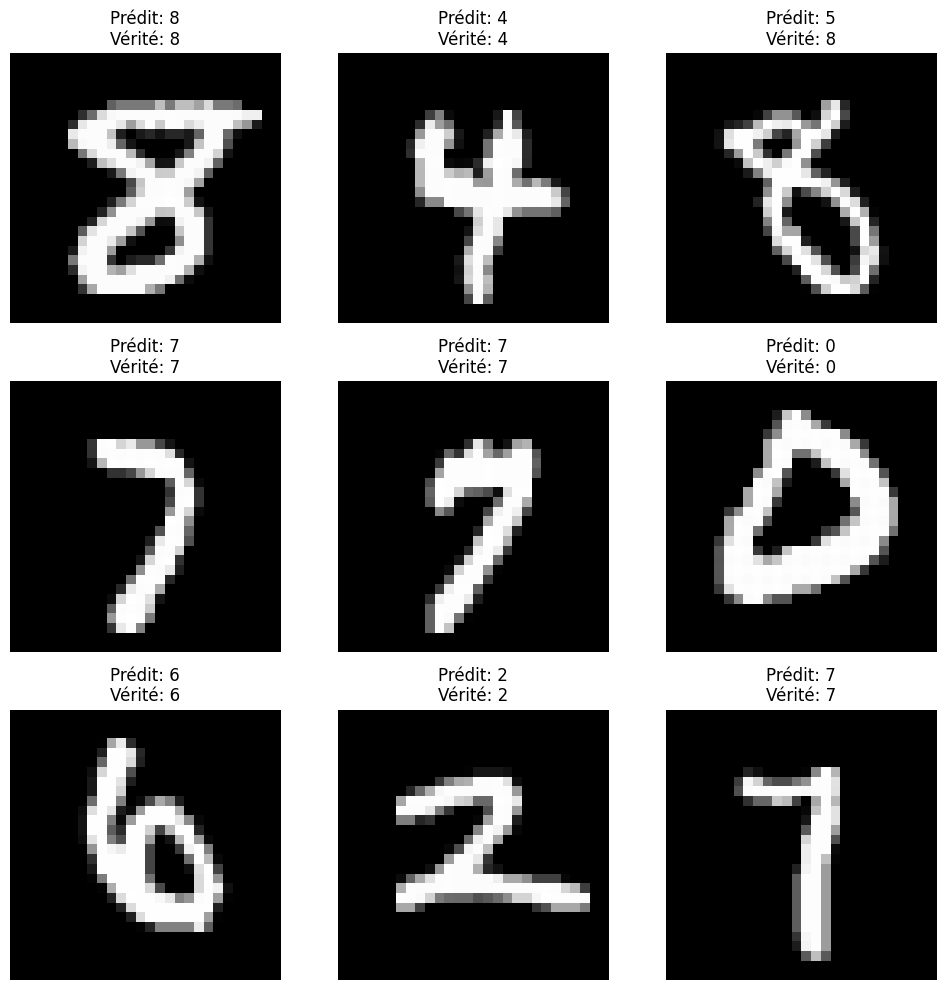


Prédictions du modèle CNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


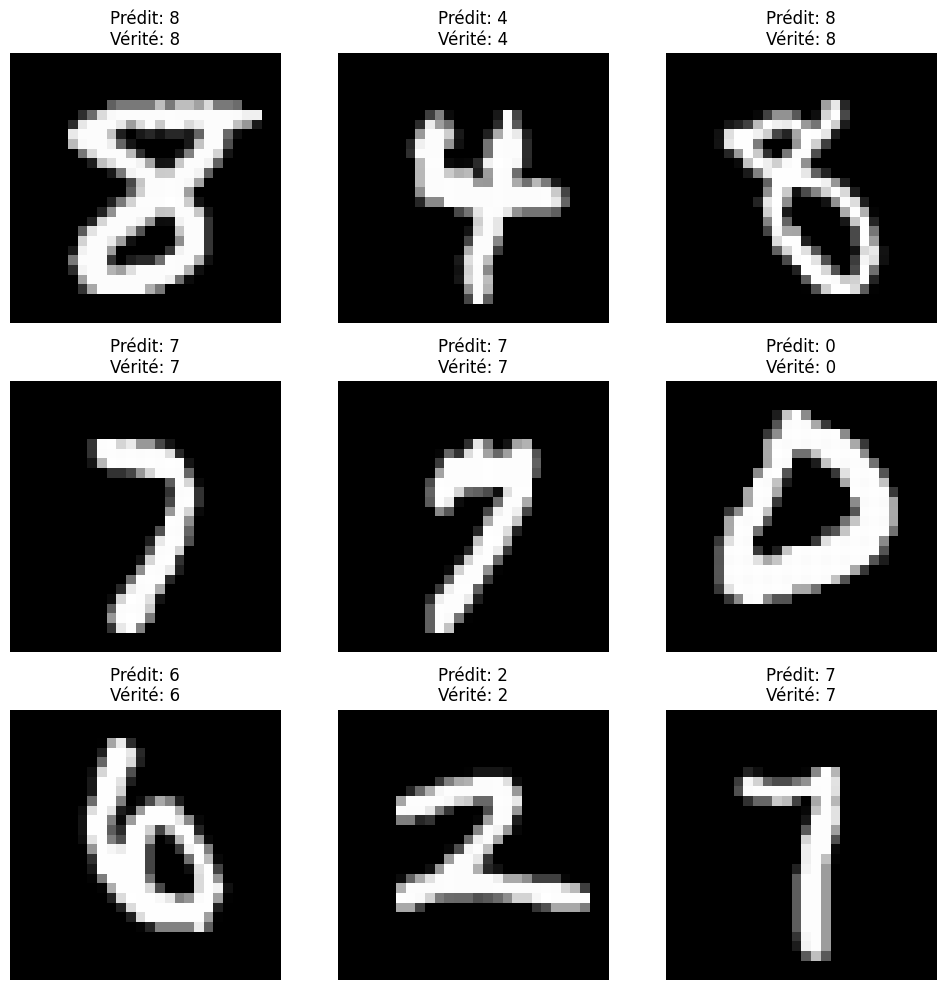


Courbes d'apprentissage - Dense:


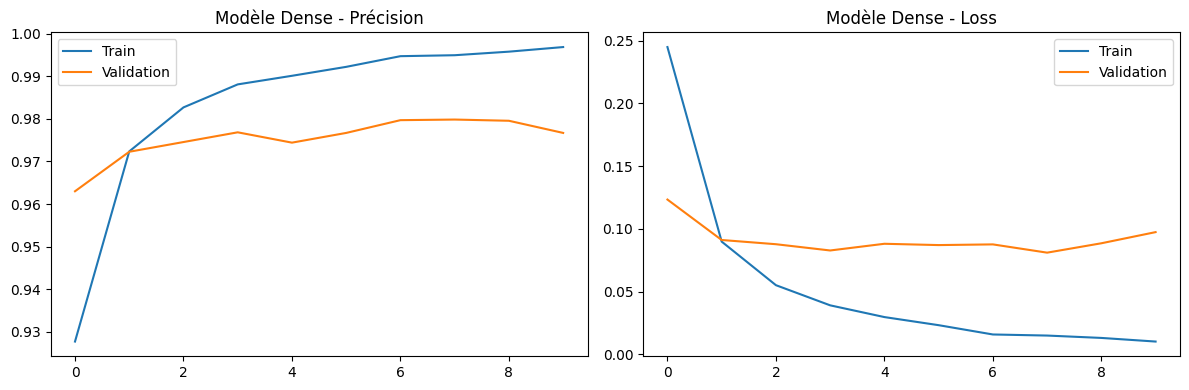


Courbes d'apprentissage - CNN:


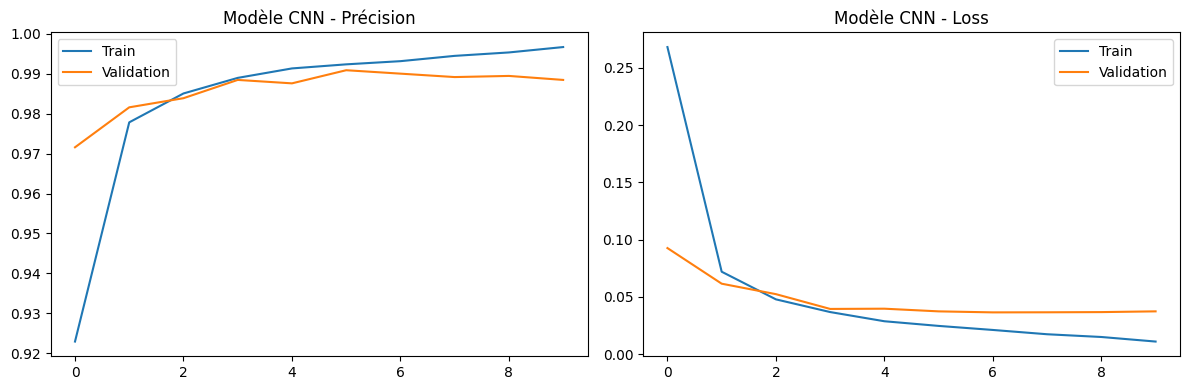


Matrice de confusion - Dense:


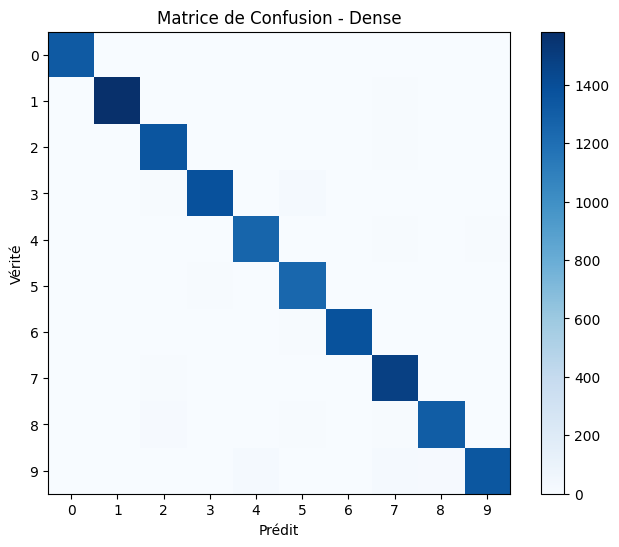


Matrice de confusion - CNN:


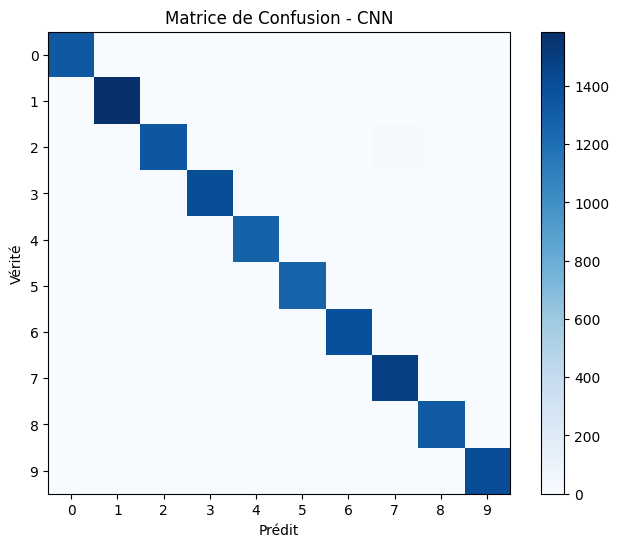

In [10]:
# Fonction d'affichage des prédictions
from sklearn.metrics import confusion_matrix

def show_predictions(model, images, labels, model_type, num_samples=9):
    plt.figure(figsize=(10, 10))
    if model_type == 'dense':
        preds = model.predict(images.reshape(-1, 28*28))
    else:  # cnn
        preds = model.predict(images.reshape(-1, 28, 28, 1))

    pred_labels = np.argmax(preds, axis=1)[:num_samples]

    for i in range(num_samples):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Prédit: {pred_labels[i]}\nVérité: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Courbes d'apprentissage
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Matrices de confusion
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(10), np.arange(10))
    plt.yticks(np.arange(10), np.arange(10))
    plt.xlabel('Prédit')
    plt.ylabel('Vérité')
    plt.show()

# Affichage des visualisations
print("\nVisualisation des résultats...")
print("\nPrédictions du modèle Dense:")
show_predictions(dense_model, test_images[:9], test_labels[:9], 'dense')

print("\nPrédictions du modèle CNN:")
show_predictions(cnn_model, test_images[:9], test_labels[:9], 'cnn')

print("\nCourbes d'apprentissage - Dense:")
plot_history(history_dense, "Modèle Dense")

print("\nCourbes d'apprentissage - CNN:")
plot_history(history_cnn, "Modèle CNN")

print("\nMatrice de confusion - Dense:")
plot_confusion_matrix(test_labels, dense_labels, "Matrice de Confusion - Dense")

print("\nMatrice de confusion - CNN:")
plot_confusion_matrix(test_labels, cnn_labels, "Matrice de Confusion - CNN")

    Performance absolue :

        CNN > Dense (99% vs 98% sur le test set)

        Le CNN est plus précis grâce à sa capacité à capturer les motifs spatiaux

    Stabilité :

        Les deux modèles montrent un bon contrôle de l'overfitting

        Le CNN présente des courbes plus lisses (meilleure généralisation)

    Vitesse de convergence :

        Le CNN atteint sa performance maximale plus rapidement

        Le Dense nécessite plus d'epochs pour se stabiliser

    Analyse des erreurs :

        Les erreurs communes concernent principalement :

            4/9 (formes similaires)

            2/7 (traits communs)

            3/5 (boucles similaires)

Recommandations :

    Le CNN est clairement supérieur

Partie 7: Analyse Approfondie


Rapport de classification - Dense:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.96      0.98      0.97      1380
           3       0.98      0.97      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.96      0.98      0.97      1273
           6       0.99      0.99      0.99      1396
           7       0.96      0.98      0.97      1503
           8       0.97      0.96      0.97      1357
           9       0.98      0.94      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000


Rapport de classification - CNN:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1343
           1       1.00      0.99      0.99      1600
        

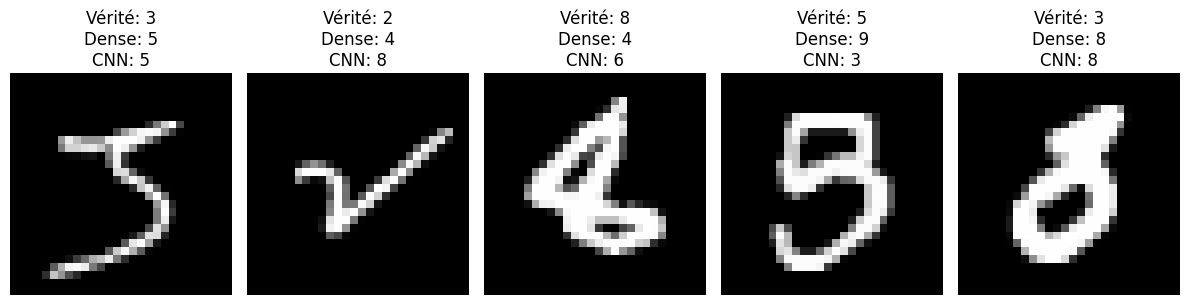

In [12]:
# Rapport de classification
from sklearn.metrics import classification_report

print("\nRapport de classification - Dense:")
print(classification_report(test_labels, dense_labels))

print("\nRapport de classification - CNN:")
print(classification_report(test_labels, cnn_labels))

# Erreurs communes
errors = (dense_labels != test_labels) & (cnn_labels != test_labels)
error_indices = np.where(errors)[0][:5]  # Premières 5 erreurs communes

if len(error_indices) > 0:
    print(f"\nExemples d'erreurs communes ({len(error_indices)} trouvées):")
    plt.figure(figsize=(12, 5))
    for i, idx in enumerate(error_indices[:5]):
        plt.subplot(1, 5, i+1)
        plt.imshow(test_images[idx], cmap='gray')
        plt.title(f"Vérité: {test_labels[idx]}\nDense: {dense_labels[idx]}\nCNN: {cnn_labels[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nAucune erreur commune trouvée entre les deux modèles!")

Ce sont les chiffres les plus ambigus (ex. un "5" mal écrit ressemblant à un "6").

Cela montre les limites même d’un modèle performant.


Conclusion générale

| Élément                | Dense      | CNN              |
| ---------------------- | ---------- | ---------------- |
| Précision test         | 0.9749     | **0.9874** ✅     |
| Courbe de validation   | Stagnation | Stable et haute  |
| Erreurs communes       | Oui        | Moins fréquentes |
| Capacité à généraliser | Moyenne    | **Très bonne** ✅ |
